In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2
np.random.seed(1)

卷积：
1. padding 
  np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values = 0)
  参数含义：(padding谁， 沿那个轴padding、padding多少， padding方式， padding的值)

In [ ]:
def zero_pad(X,pad):
#     X_paded = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values = 0)    
    X_paded = np.pad(X,(
                        (0,0),       #样本数，不填充
                        (pad,pad),   #图像高度,你可以视为上面填充x个，下面填充y个(x,y)
                        (pad,pad),   #图像宽度,你可以视为左边填充x个，右边填充y个(x,y)
                        (0,0)),      #通道数，不填充
                        'constant', constant_values=0)      #连续一样的值填充
    return X_paded

In [ ]:
np.random.seed(1)
x = np.random.randn(4,3,3,2)
x_paded = zero_pad(x,2)
#查看信息
print ("x.shape =", x.shape)
print ("x_paded.shape =", x_paded.shape)
print ("x[1, 1] =", x[1, 1])
print ("x_paded[1, 1] =", x_paded[1, 1])

#绘制图
fig , axarr = plt.subplots(1,2)  #一行两列
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_paded')
axarr[1].imshow(x_paded[0,:,:,0])

In [ ]:
def conv_single_step(a_slice_prev, W, b):  #  取出来的3维长方体和W的大小相同，做卷积，每个通道变成一个数，所有通道再相加，就是最后卷积值
    s = np.multiply(a_slice_prev, W) + b
    Z = np.sum(s)
    return Z
np.random.seed(1)

#这里切片大小和过滤器大小相同
a_slice_prev = np.random.randn(4,4,3)
W = np.random.randn(4,4,3)
b = np.random.randn(1,1,1)

Z = conv_single_step(a_slice_prev,W,b)

print("Z = " + str(Z))




In [ ]:
def conv_forward(A_prev, W, b, hparameters):
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    pad = hparameters["pad"]
    stride = hparameters["stride"]
    A_prev_pad = zero_pad(A_prev, pad)
    
    n_H = int((n_H_prev + 2 * pad - f) / stride) + 1
    n_W = int((n_W_prev + 2 * pad - f) / stride) + 1
    Z = np.zeros((m, n_H, n_W, n_C))
    for i in range(m):
        i_A_prev_pad = A_prev_pad[i] # 取出第i个padding的图像
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = stride * h
                    vert_end = vert_start + f
                    horiz_start = stride * w
                    horiz_end = horiz_start + f
                    a_slice_prev = i_A_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]  #取出小长条，所有通道的小图块堆叠成的
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:, :, :, c], b[0, 0, 0, c])
    
    assert(Z.shape == (m, n_H, n_W, n_C))
    cache = (A_prev, W, b, hparameters)                
    return (Z , cache)

In [ ]:
np.random.seed(1)

A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)

hparameters = {"pad" : 2, "stride": 1}

Z , cache_conv = conv_forward(A_prev,W,b,hparameters)

print("np.mean(Z) = ", np.mean(Z))
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

In [ ]:
def pool_forward(A_prev,hparameters,mode="max"):
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    f = hparameters["f"]
    stride = hparameters["stride"]
    n_H = int((n_H_prev - f) / stride) + 1
    n_W = int((n_W_prev - f) / stride) + 1
    n_C = n_C_prev  #池化层通道数不变，只是每个通道尺寸变小
    A = np.zeros((m, n_H, n_W, n_C))
    for i in range(m):
        i_image = A_prev[i,:,:,:] #取出第i个
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    h_start = h * stride
                    h_end = h_start + f
                    w_start = w * stride
                    w_end = w_start + f
                    a_slice_prev = A_prev[i, h_start:h_end, w_start:w_end, c]  # 取出小长条,进行pooling操作
                    
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_slice_prev)  #numpy基本函数，取最大值
                    if mode == "average":
                        A[i, h, w, c] = np.mean(a_slice_prev)
    assert(A.shape == (m, n_H, n_W, n_C)) 
    cache = (A_prev, hparameters)
    return A,cache

In [ ]:
np.random.seed(1)
A_prev = np.random.randn(2,4,4,3)
hparameters = {"f":4 , "stride":1}

A , cache = pool_forward(A_prev,hparameters,mode="max")
A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print("----------------------------")
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

In [ ]:
# 卷积的反向传播原理

In [3]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as maimg
import tensorflow as tf
from tensorflow.python.framework import ops
import cnn_utils
%matplotlib inline
np.random.seed(1)

D:\installFile\anaconda\envs\DL_py36_study\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\installFile\anaconda\envs\DL_py36_study\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\installFile\anaconda\envs\DL_py36_study\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\installFile\anaconda\envs\DL_py36_study\lib\site-

In [4]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = cnn_utils.load_dataset()

y = 2


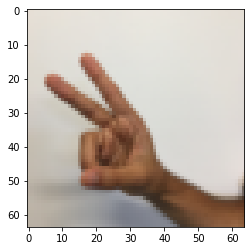

In [5]:
index = 6
plt.imshow(train_set_x_orig[index])
print ("y = " + str(np.squeeze(train_set_y_orig[:, index])))

In [31]:
X_train = train_set_x_orig / 255
X_test = test_set_x_orig / 255
Y_train = cnn_utils.convert_to_one_hot(train_set_y_orig, 6).T
Y_test = cnn_utils.convert_to_one_hot(test_set_y_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}


number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [32]:
# 创建placeholder
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])  # 输入图片的数量不定，所以设置为None
    Y = tf.placeholder(tf.float32, [None, n_y])   # 矩阵的行数代表输入图片的数量
    return X,Y

In [33]:
X , Y = create_placeholders(64,64,3,6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder_2:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_3:0", shape=(?, 6), dtype=float32)


In [34]:
# 初始化参数
def initialize_parameters():
    tf.set_random_seed(1)
    w1 = tf.get_variable("W1", [4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    w2 = tf.get_variable("W2", [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    parameters = {"W1":w1, "W2":w2}
    return parameters

In [35]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

    sess_test.close()

W1 = [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


In [36]:
# def forward_propagation(X, parameters):
#     # 取出参数
#     w1 = parameters["W1"]
#     w2 = parameters["W2"]
#     Z1 = tf.nn.conv2d(X, w1, strides = [1, 1, 1, 1], padding = "SAME")  # 第三个参数表示沿4个轴移动的步子
#     A1 = tf.nn.relu(Z1)
#     P1 = tf.nn.max_pool(A1, ksize = [1, 8, 8, 1], strides = [1, 8, 8, 1], padding = "SAME")
    
#     Z2 = tf.nn.conv2d(P1, w2, strides = [1, 1, 1, 1], padding = "SAME")
#     A2 = tf.nn.relu(Z2)
#     P2 = tf.nn.max_pool(A2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding = "SAME")
    
#     P = tf.contrib.layers.flatten(P2)
#     Z3 = tf.contrib.layers.fully_connected(P, 6, activation_fn = None)
#     return Z3


def forward_propagation(X,parameters):
    """
    实现前向传播
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    参数：
        X - 输入数据的placeholder，维度为(输入节点数量，样本数量)
        parameters - 包含了“W1”和“W2”的python字典。

    返回：
        Z3 - 最后一个LINEAR节点的输出

    """
    W1 = parameters['W1']
    W2 = parameters['W2']

    #Conv2d : 步伐：1，填充方式：“SAME”
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding="SAME")
    #ReLU ：
    A1 = tf.nn.relu(Z1)
    #Max pool : 窗口大小：8x8，步伐：8x8，填充方式：“SAME”
    P1 = tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding="SAME")

    #Conv2d : 步伐：1，填充方式：“SAME”
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding="SAME")
    #ReLU ：
    A2 = tf.nn.relu(Z2)
    #Max pool : 过滤器大小：4x4，步伐：4x4，填充方式：“SAME”
    P2 = tf.nn.max_pool(A2,ksize=[1,4,4,1],strides=[1,4,4,1],padding="SAME")

    #一维化上一层的输出
    P = tf.contrib.layers.flatten(P2)

    #全连接层（FC）：使用没有非线性激活函数的全连接层
    Z3 = tf.contrib.layers.fully_connected(P,6,activation_fn=None)  # 0轴代表样本数量

    return Z3


In [37]:
tf.reset_default_graph()
np.random.seed(1)

with tf.Session() as sess_test:
    X,Y = create_placeholders(64,64,3,6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)

    init = tf.global_variables_initializer()
    sess_test.run(init)

    a = sess_test.run(Z3,{X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = " + str(a))

    sess_test.close()



Z3 = [[ 1.4416982  -0.24909668  5.4504995  -0.2618962  -0.20669872  1.3654671 ]
 [ 1.4070847  -0.02573182  5.08928    -0.4866991  -0.4094069   1.2624853 ]]


In [ ]:
def compute_cost(Z3,Y):
    cost = tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y)
    cost = tf.reduce_mean(cost)
    return cost
tf.reset_default_graph()

with tf.Session() as sess_test:
    np.random.seed(1)
    X,Y = create_placeholders(64,64,3,6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    cost = compute_cost(Z3,Y)

    init = tf.global_variables_initializer()
    sess_test.run(init)
    a = sess_test.run(cost,{X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))

    sess_test.close()


1. 创建占位符
2. 初始化参数
3. 前向传播
4. 计算loss
5. 反向计算
6. 创建优化器，求最优参数

In [83]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009, num_epochs = 100, minibatch_size = 64, print_cost = True, isPlot = True):
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3  #指定numpy的种子
    
    
    # 调用自己写的函数，创建placeholder， 后面要用session给占位符喂数据
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]  # Y_train行数是标签个数
    costs = []
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    # 初始化参数
    parameters = initialize_parameters()
    
    # 前向传播
    Z3 = forward_propagation(X,parameters)
    # 计算loss
    cost = compute_cost(Z3,Y)
    # 反向传播
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()  # 全局初始化变量
    # 以上只是创建图，没有喂数据进行实际计算，下面创建session进行实际计算
    with tf.Session() as sess: 
        sess.run(init)
        
        #  进行喂数据，计算
        for epoch in range(num_epochs):
            cost_epoch = 0
            num_minibatch = int(X_train.shape[0] / minibatch_size)
            seed = seed + 1
            minibatches = cnn_utils.random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for i_batch in minibatches:
                (x_batch, y_batch) = i_batch
                
                # 第i_batch小批量数据的梯度下降
                _, cost_i_batch = sess.run([optimizer, cost], feed_dict = {X:x_batch, Y:y_batch})
                cost_epoch += cost_i_batch / num_minibatch
            if print_cost:
                if epoch % 5 == 0:
                    print("{}th epoch\t|cost = {}".format(epoch, cost_epoch))
            if epoch % 1 == 0:
                costs.append(cost_epoch)
                
        if isPlot:
            print("costs.type:", type(costs))
            plt.plot(np.squeeze(costs))
            plt.ylabel("cost")
            plt.xlabel("epoch")
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()

        current_predict = tf.equal(tf.arg_max(Z3, 1), tf.arg_max(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(current_predict, "float"))
        print("accuracy :", accuracy)

        accuracy_train = accuracy.eval({X:X_train, Y:Y_train}) 
        accuracy_test = accuracy.eval({X:X_test, Y:Y_test})
        print("train accuracy :", accuracy_train)
        print("test accuracy:", accuracy_test)
        
    return (accuracy_train,accuracy_test,parameters)



0th epoch	|cost = 1.9213323965668678
5th epoch	|cost = 1.9041557759046555
10th epoch	|cost = 1.9043088480830193
15th epoch	|cost = 1.904477171599865
20th epoch	|cost = 1.9018685296177864
25th epoch	|cost = 1.7401809096336365
30th epoch	|cost = 1.6646495833992958
35th epoch	|cost = 1.626261167228222
40th epoch	|cost = 1.6200454384088516
45th epoch	|cost = 1.5801728665828705
50th epoch	|cost = 1.550707258284092
55th epoch	|cost = 1.4860153198242188
60th epoch	|cost = 1.3735136091709137
65th epoch	|cost = 1.2669073417782784
70th epoch	|cost = 1.1806523390114307
75th epoch	|cost = 1.1412195302546024
80th epoch	|cost = 1.0724785141646862
85th epoch	|cost = 1.0686000622808933
90th epoch	|cost = 1.0151213817298412
95th epoch	|cost = 0.9881901554763317
100th epoch	|cost = 1.0072355084121227
105th epoch	|cost = 0.9636502638459206
110th epoch	|cost = 0.9690168127417564
115th epoch	|cost = 0.9555537402629852
120th epoch	|cost = 0.946508813649416
125th epoch	|cost = 0.892060186713934
130th epoch	|

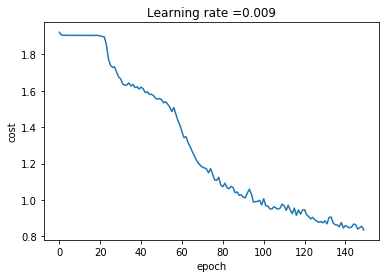

accuracy : Tensor("Mean_1:0", shape=(), dtype=float32)
train accuracy : 0.725
test accuracy: 0.575


In [84]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test,num_epochs=150)